# AI Safety Training Methods Scaling Analysis

**Analyzing safety training effectiveness and scaling behavior following SafetyWashing methodology**

## Research Questions

1. **Do benchmarks saturate with scale?** (Vanilla performance vs scale)
2. **Do techniques show increasing performance gain with scale?** (Safety gain vs scale)
3. **Can we categorize techniques and benchmarks by their scaling properties?**

---

**Key Principles**:
- Analyze **individual data points** (no aggregation)
- Calculate **slopes** to characterize scaling behavior
- Categorize by correlation with scale

## Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("✓ All imports successful")

✓ All imports successful


## 1. Load and Preprocess Data

In [2]:
# Load dataset
df = pd.read_csv('../data/updated_data.csv')

# Normalize data for consistency
# 1. Normalize Technique names (handle case inconsistency)
df['Technique'] = df['Technique'].str.strip()
df['Technique'] = df['Technique'].replace({'baseline': 'Baseline'})

# 2. Normalize Benchmark names (uppercase for consistency)
df['Benchmark'] = df['Benchmark'].str.upper().str.strip()

# 3. Use existing 'Scale number' column as scale_numeric
df['scale_numeric'] = df['Scale number']

# 4. Remove any rows with missing critical data
df = df.dropna(subset=['scale_numeric', 'Benchmark perf', 'Technique'])

print("Dataset Overview:")
print("="*60)
print(f"Total data points: {len(df)}")
print(f"\nModels ({len(df['Model'].unique())} unique):")
print(f"  {', '.join(sorted(df['Model'].unique())[:5])}...")
print(f"\nBenchmarks ({len(df['Benchmark'].unique())} unique):")
print(f"  {', '.join(sorted(df['Benchmark'].unique()))}")
print(f"\nTechniques ({len(df['Technique'].unique())} unique):")
for tech in sorted(df['Technique'].unique())[:10]:
    count = len(df[df['Technique'] == tech])
    print(f"  - {tech}: {count} data points")
if len(df['Technique'].unique()) > 10:
    print(f"  ... and {len(df['Technique'].unique()) - 10} more techniques")
print(f"\nScale range: {df['scale_numeric'].min():.0f}B - {df['scale_numeric'].max():.0f}B parameters")
print(f"\nBaseline data points: {len(df[df['Technique'] == 'Baseline'])}")

# Show sample data
print("\nSample data:")
df.head(10)

Dataset Overview:
Total data points: 189

Models (13 unique):
  DeepSeek-V2-Chat, Llama-3-8B, Llama-3.2-1B, Llama3-8BInstruct, MIXTRAL-8X7B...

Benchmarks (4 unique):
  BIO, CHEM, CYBER, MMLU

Techniques (22 unique):
  - Baseline: 44 data points
  - ECO (Ours): 20 data points
  - ELM: 8 data points
  - Gradient ascent: 3 data points
  - Gradient ascent - LAT: 3 data points
  - LLMU: 11 data points
  - MUDMAN: 1 data points
  - No unlearning applied, but after relearning: 1 data points
  - Prompting: 20 data points
  - RMU: 26 data points
  ... and 12 more techniques

Scale range: 1B - 236B parameters

Baseline data points: 44

Sample data:


,Source paper,Technique,Model,Scale,Benchmark,Benchmark perf,Scale number,scale_numeric
0,https://arxiv.org/pdf/2403.03218,Baseline,ZEPHYR-7B,7B,BIO,0.637,7,7
1,https://arxiv.org/pdf/2403.03219,Baseline,ZEPHYR-7B,7B,CHEM,0.458,7,7
2,https://arxiv.org/pdf/2403.03220,Baseline,ZEPHYR-7B,7B,MMLU,0.581,7,7
3,https://arxiv.org/pdf/2403.03219,Baseline,ZEPHYR-7B,7B,CYBER,0.440,7,7
4,https://arxiv.org/pdf/2403.03220,LLMU,ZEPHYR-7B,7B,BIO,0.595,7,7
5,https://arxiv.org/pdf/2403.03221,LLMU,ZEPHYR-7B,7B,CHEM,0.414,7,7
6,https://arxiv.org/pdf/2403.03222,LLMU,ZEPHYR-7B,7B,MMLU,0.447,7,7
7,https://arxiv.org/pdf/2403.03223,LLMU,ZEPHYR-7B,7B,CYBER,0.395,7,7
8,https://arxiv.org/pdf/2403.03224,SCRUB,ZEPHYR-7B,7B,BIO,0.438,7,7
9,https://arxiv.org/pdf/2403.03225,SCRUB,ZEPHYR-7B,7B,CHEM,0.404,7,7


## 2. Analyze Vanilla Scaling Behavior (Benchmark Saturation)

**Goal**: Determine if vanilla model performance correlates with scale

- **Positive correlation** = Benchmark solved by scale (saturated)
- **No/negative correlation** = Benchmark not solved by scale

In [3]:
# Extract baseline data only
baseline_df = df[df['Technique'] == 'Baseline'].copy()

# Calculate correlation and slope for each benchmark
benchmark_scaling = []

for benchmark in baseline_df['Benchmark'].unique():
    bench_data = baseline_df[baseline_df['Benchmark'] == benchmark]
    
    # Get scale and performance
    scales = bench_data['scale_numeric'].values
    perfs = bench_data['Benchmark perf'].values
    
    if len(scales) >= 2:
        # Calculate Spearman correlation (follows SafetyWashing methodology)
        corr, p_value = spearmanr(scales, perfs)
        
        # Fit linear regression to get slope
        model = LinearRegression()
        model.fit(scales.reshape(-1, 1), perfs)
        slope = model.coef_[0]
        r2 = model.score(scales.reshape(-1, 1), perfs)
        
        benchmark_scaling.append({
            'Benchmark': benchmark,
            'Correlation': corr,
            'P_value': p_value,
            'Slope': slope,
            'R2': r2,
            'N_points': len(scales),
            'Category': 'Saturated' if corr > 0.5 else 'Not Saturated'
        })

bench_scaling_df = pd.DataFrame(benchmark_scaling)

print("\nBenchmark Scaling Analysis (Baseline Models)")
print("="*80)
print(f"{'Benchmark':<20} {'Correlation':<12} {'Slope':<12} {'R²':<8} {'Category'}")
print("="*80)
for _, row in bench_scaling_df.iterrows():
    print(f"{row['Benchmark']:<20} {row['Correlation']:>11.3f} {row['Slope']:>11.4f} {row['R2']:>7.3f} {row['Category']}")

bench_scaling_df


Benchmark Scaling Analysis (Baseline Models)
Benchmark            Correlation  Slope        R²       Category
BIO                        0.830      0.0004   0.333 Saturated
CHEM                       0.630      0.0003   0.279 Saturated
MMLU                       0.836      0.0006   0.467 Saturated
CYBER                      0.651      0.0002   0.110 Saturated


,Benchmark,Correlation,P_value,Slope,R2,N_points,Category
0,BIO,0.829755,0.000840,0.000433,0.332619,12,Saturated
1,CHEM,0.629930,0.069028,0.000320,0.279256,9,Saturated
2,MMLU,0.836373,0.001333,0.000607,0.466839,11,Saturated
3,CYBER,0.651430,0.021741,0.000219,0.109554,12,Saturated


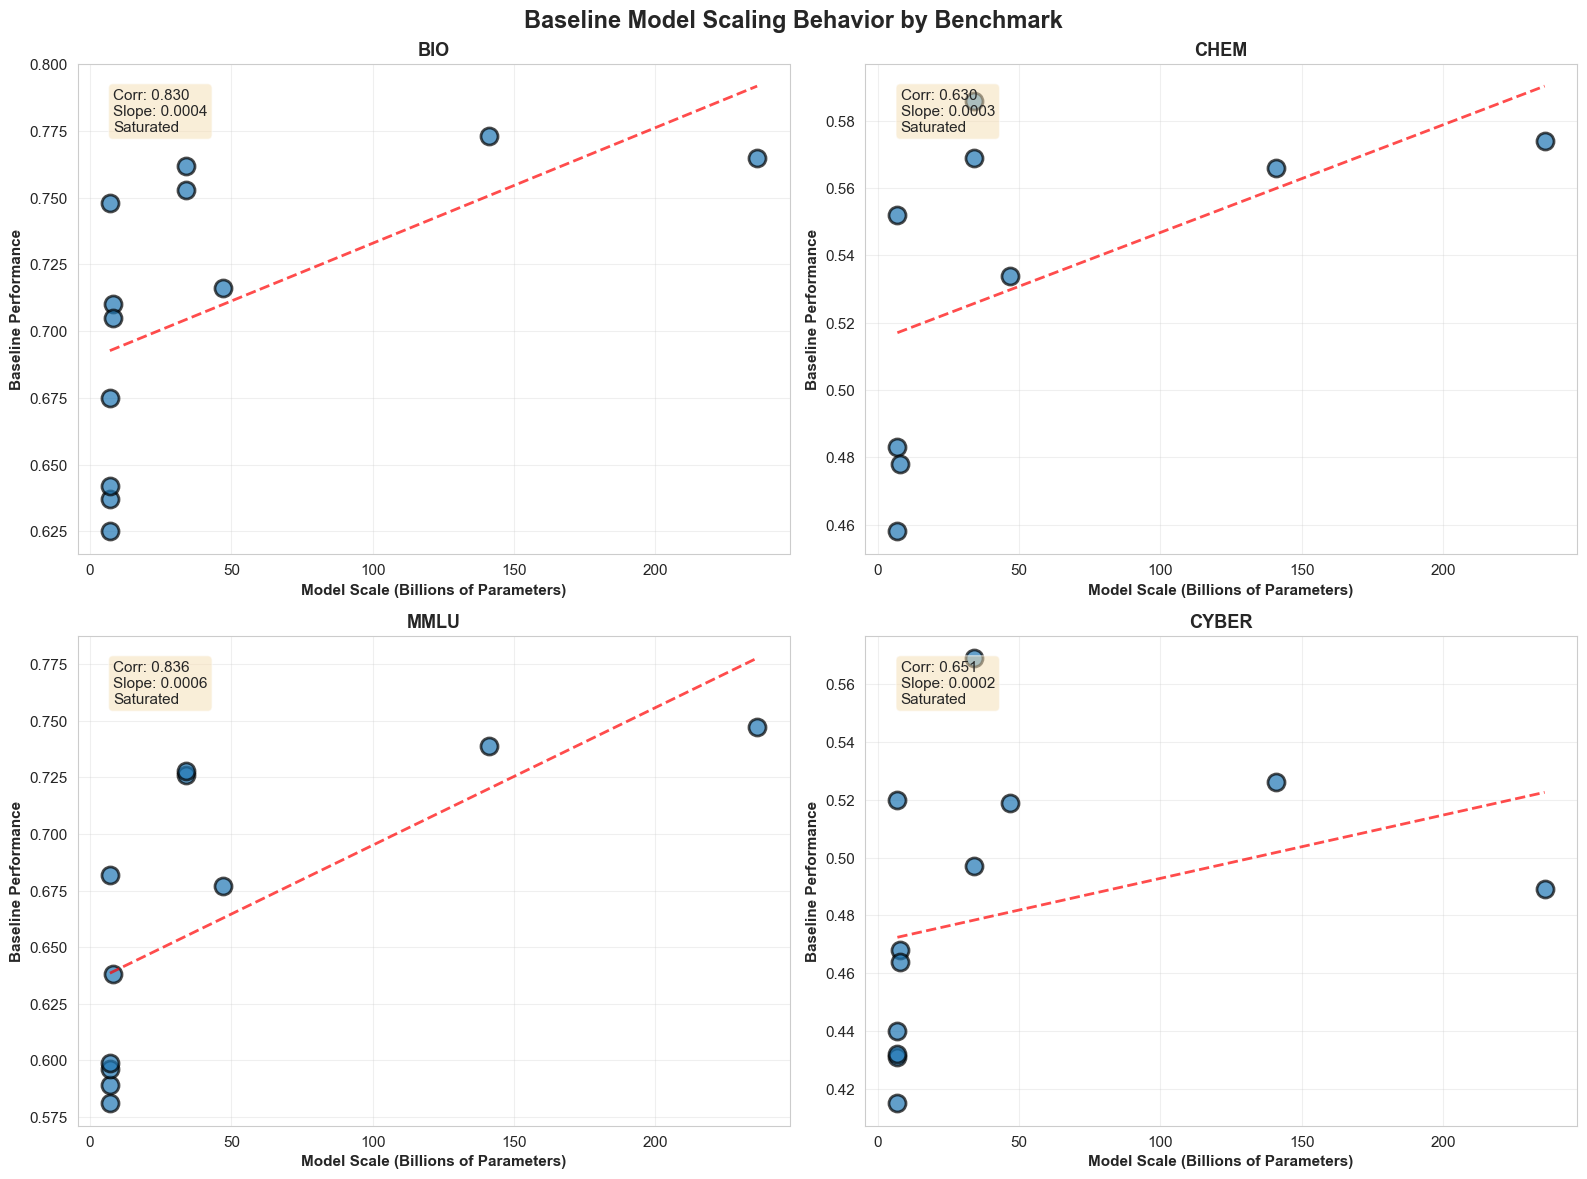


✓ Baseline scaling analysis complete


In [4]:
# Visualize baseline scaling for each benchmark
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, benchmark in enumerate(baseline_df['Benchmark'].unique()):
    if idx >= len(axes):
        break
    ax = axes[idx]
    bench_data = baseline_df[baseline_df['Benchmark'] == benchmark]
    
    # Scatter plot of individual points
    ax.scatter(bench_data['scale_numeric'], bench_data['Benchmark perf'],
              s=150, alpha=0.7, edgecolors='black', linewidth=2)
    
    # Fit and plot trend line
    if len(bench_data) >= 2:
        scales = bench_data['scale_numeric'].values.reshape(-1, 1)
        perfs = bench_data['Benchmark perf'].values
        model = LinearRegression()
        model.fit(scales, perfs)
        
        # Plot trend line
        scale_range = np.linspace(scales.min(), scales.max(), 100)
        pred = model.predict(scale_range.reshape(-1, 1))
        ax.plot(scale_range, pred, 'r--', linewidth=2, alpha=0.7)
        
        # Get stats
        stats_row = bench_scaling_df[bench_scaling_df['Benchmark'] == benchmark]
        if len(stats_row) > 0:
            stats_row = stats_row.iloc[0]
            ax.text(0.05, 0.95, 
                   f"Corr: {stats_row['Correlation']:.3f}\nSlope: {stats_row['Slope']:.4f}\n{stats_row['Category']}",
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.set_xlabel('Model Scale (Billions of Parameters)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Baseline Performance', fontsize=11, fontweight='bold')
    ax.set_title(f'{benchmark}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)

# Remove extra subplots if fewer than 4 benchmarks
for idx in range(len(baseline_df['Benchmark'].unique()), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Baseline Model Scaling Behavior by Benchmark',
            fontsize=17, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Baseline scaling analysis complete")

## 3. Calculate Performance Difference from Vanilla (Individual Data Points)

**Metric**: Absolute difference = Safety Performance - Vanilla Performance

- **Positive difference** = Safety method outperforms vanilla
- **Negative difference** = Safety method underperforms vanilla

In [5]:
# Calculate difference from baseline for each data point
diff_data = []

for model in df['Model'].unique():
    for scale in df[df['Model'] == model]['Scale'].unique():
        for benchmark in df['Benchmark'].unique():
            subset = df[
                (df['Model'] == model) &
                (df['Scale'] == scale) &
                (df['Benchmark'] == benchmark)
            ]
            
            # Get baseline performance
            baseline_perf = subset[subset['Technique'] == 'Baseline']['Benchmark perf']
            if len(baseline_perf) == 0:
                continue
            
            baseline_val = baseline_perf.values[0]
            scale_numeric = subset['scale_numeric'].values[0]
            
            # Calculate difference for each safety/unlearning technique
            # (all techniques except Baseline)
            for technique in subset['Technique'].unique():
                if technique == 'Baseline':
                    continue
                    
                tech_perf = subset[subset['Technique'] == technique]['Benchmark perf']
                if len(tech_perf) > 0:
                    tech_val = tech_perf.values[0]
                    diff = tech_val - baseline_val  # Absolute difference
                    
                    diff_data.append({
                        'Model': model,
                        'Scale': scale,
                        'scale_numeric': scale_numeric,
                        'Benchmark': benchmark,
                        'Technique': technique,
                        'Baseline_perf': baseline_val,
                        'Safety_perf': tech_val,
                        'Diff_from_baseline': diff,
                        'Relative_change_pct': (diff / baseline_val) * 100 if baseline_val != 0 else 0
                    })

diff_df = pd.DataFrame(diff_data)

print("\nPerformance Difference from Baseline (Individual Data Points)")
print("="*60)
print(f"Total data points: {len(diff_df)}")
print(f"\nData points per technique:")
print(diff_df['Technique'].value_counts().head(10))
if len(diff_df['Technique'].unique()) > 10:
    print(f"... and {len(diff_df['Technique'].unique()) - 10} more techniques")
print(f"\nSample of data:")
diff_df.head(10)


Performance Difference from Baseline (Individual Data Points)
Total data points: 133

Data points per technique:
Technique
RMU                24
Prompting          20
ECO (Ours)         20
RMU (OURS)         12
LLMU               11
SCRUB               8
SSD                 8
RR                  6
ELM                 6
Gradient ascent     3
Name: count, dtype: int64
... and 5 more techniques

Sample of data:


,Model,Scale,scale_numeric,Benchmark,Technique,Baseline_perf,Safety_perf,Diff_from_baseline,Relative_change_pct
0,ZEPHYR-7B,7B,7,BIO,LLMU,0.637,0.595,-0.042,-6.593407
1,ZEPHYR-7B,7B,7,BIO,SCRUB,0.637,0.438,-0.199,-31.240188
2,ZEPHYR-7B,7B,7,BIO,SSD,0.637,0.502,-0.135,-21.193093
3,ZEPHYR-7B,7B,7,BIO,RMU (OURS),0.637,0.312,-0.325,-51.020408
4,ZEPHYR-7B,7B,7,CHEM,LLMU,0.458,0.414,-0.044,-9.606987
5,ZEPHYR-7B,7B,7,CHEM,SCRUB,0.458,0.404,-0.054,-11.790393
6,ZEPHYR-7B,7B,7,CHEM,SSD,0.458,0.338,-0.120,-26.200873
7,ZEPHYR-7B,7B,7,CHEM,RMU (OURS),0.458,0.458,0.000,0.000000
8,ZEPHYR-7B,7B,7,MMLU,LLMU,0.581,0.447,-0.134,-23.063683
9,ZEPHYR-7B,7B,7,MMLU,SCRUB,0.581,0.512,-0.069,-11.876076


## 4. Analyze Technique Scaling Behavior (Performance Gain vs Scale)

**Goal**: Determine if performance gain increases with scale

For each (technique, benchmark) pair:
- Calculate correlation between scale and performance gain
- **Positive slope** = Performance gain increases with scale
- **Negative slope** = Performance gain decreases with scale

In [6]:
# Analyze scaling behavior for each technique-benchmark combination
technique_scaling = []

for technique in diff_df['Technique'].unique():
    for benchmark in diff_df['Benchmark'].unique():
        subset = diff_df[
            (diff_df['Technique'] == technique) &
            (diff_df['Benchmark'] == benchmark)
        ]
        
        if len(subset) >= 2:
            scales = subset['scale_numeric'].values
            diffs = subset['Diff_from_baseline'].values
            
            # Calculate Spearman correlation
            corr, p_value = spearmanr(scales, diffs)
            
            # Fit linear regression
            model = LinearRegression()
            model.fit(scales.reshape(-1, 1), diffs)
            slope = model.coef_[0]
            r2 = model.score(scales.reshape(-1, 1), diffs)
            
            # Categorize
            if corr > 0.3:
                category = 'Gain Increases with Scale'
            elif corr < -0.3:
                category = 'Gain Decreases with Scale'
            else:
                category = 'Gain Stable with Scale'
            
            technique_scaling.append({
                'Technique': technique,
                'Benchmark': benchmark,
                'Correlation': corr,
                'P_value': p_value,
                'Slope': slope,
                'R2': r2,
                'N_points': len(scales),
                'Category': category,
                'Mean_diff': diffs.mean()
            })

tech_scaling_df = pd.DataFrame(technique_scaling)

print("\nTechnique Scaling Analysis (Performance Gain vs Scale)")
print("="*100)
print(f"{'Technique':<25} {'Benchmark':<10} {'Corr':<8} {'Slope':<10} {'R²':<8} {'Category'}")
print("="*100)
for _, row in tech_scaling_df.sort_values(['Technique', 'Benchmark']).head(20).iterrows():
    print(f"{row['Technique']:<25} {row['Benchmark']:<10} {row['Correlation']:>7.3f} "
          f"{row['Slope']:>9.4f} {row['R2']:>7.3f} {row['Category']}")

if len(tech_scaling_df) > 20:
    print(f"... and {len(tech_scaling_df) - 20} more technique-benchmark combinations")

print("\n" + "="*100)
tech_scaling_df.head(15)


Technique Scaling Analysis (Performance Gain vs Scale)
Technique                 Benchmark  Corr     Slope      R²       Category
ECO (Ours)                BIO         -0.900   -0.0004   0.582 Gain Decreases with Scale
ECO (Ours)                CHEM        -0.300   -0.0002   0.177 Gain Stable with Scale
ECO (Ours)                CYBER       -0.100   -0.0001   0.030 Gain Stable with Scale
ECO (Ours)                MMLU           nan    0.0000   1.000 Gain Stable with Scale
ELM                       BIO          1.000    0.0550   1.000 Gain Increases with Scale
ELM                       CYBER       -1.000   -0.0340   1.000 Gain Decreases with Scale
ELM                       MMLU         1.000    0.1720   1.000 Gain Increases with Scale
LLMU                      BIO         -0.866   -0.3615   1.000 Gain Decreases with Scale
LLMU                      CHEM        -0.866   -0.1205   0.969 Gain Decreases with Scale
LLMU                      CYBER       -0.866   -0.1475   0.997 Gain Decreases

,Technique,Benchmark,Correlation,P_value,Slope,R2,N_points,Category,Mean_diff
0,LLMU,BIO,-0.866025,0.333333,-0.361500,0.999857,3,Gain Decreases with Scale,-0.165000
1,LLMU,CHEM,-0.866025,0.333333,-0.120500,0.968727,3,Gain Decreases with Scale,-0.096667
2,LLMU,MMLU,NaN,NaN,0.000000,0.000000,2,Gain Stable with Scale,-0.138000
3,LLMU,CYBER,-0.866025,0.333333,-0.147500,0.997215,3,Gain Decreases with Scale,-0.089667
4,SCRUB,BIO,NaN,NaN,0.000000,0.000000,2,Gain Stable with Scale,-0.201500
5,SCRUB,CHEM,NaN,NaN,0.000000,0.000000,2,Gain Stable with Scale,-0.066500
6,SCRUB,MMLU,NaN,NaN,0.000000,0.000000,2,Gain Stable with Scale,-0.073000
7,SCRUB,CYBER,NaN,NaN,0.000000,0.000000,2,Gain Stable with Scale,-0.042500
8,SSD,BIO,NaN,NaN,0.000000,0.000000,2,Gain Stable with Scale,-0.137500
9,SSD,CHEM,NaN,NaN,0.000000,0.000000,2,Gain Stable with Scale,-0.132500


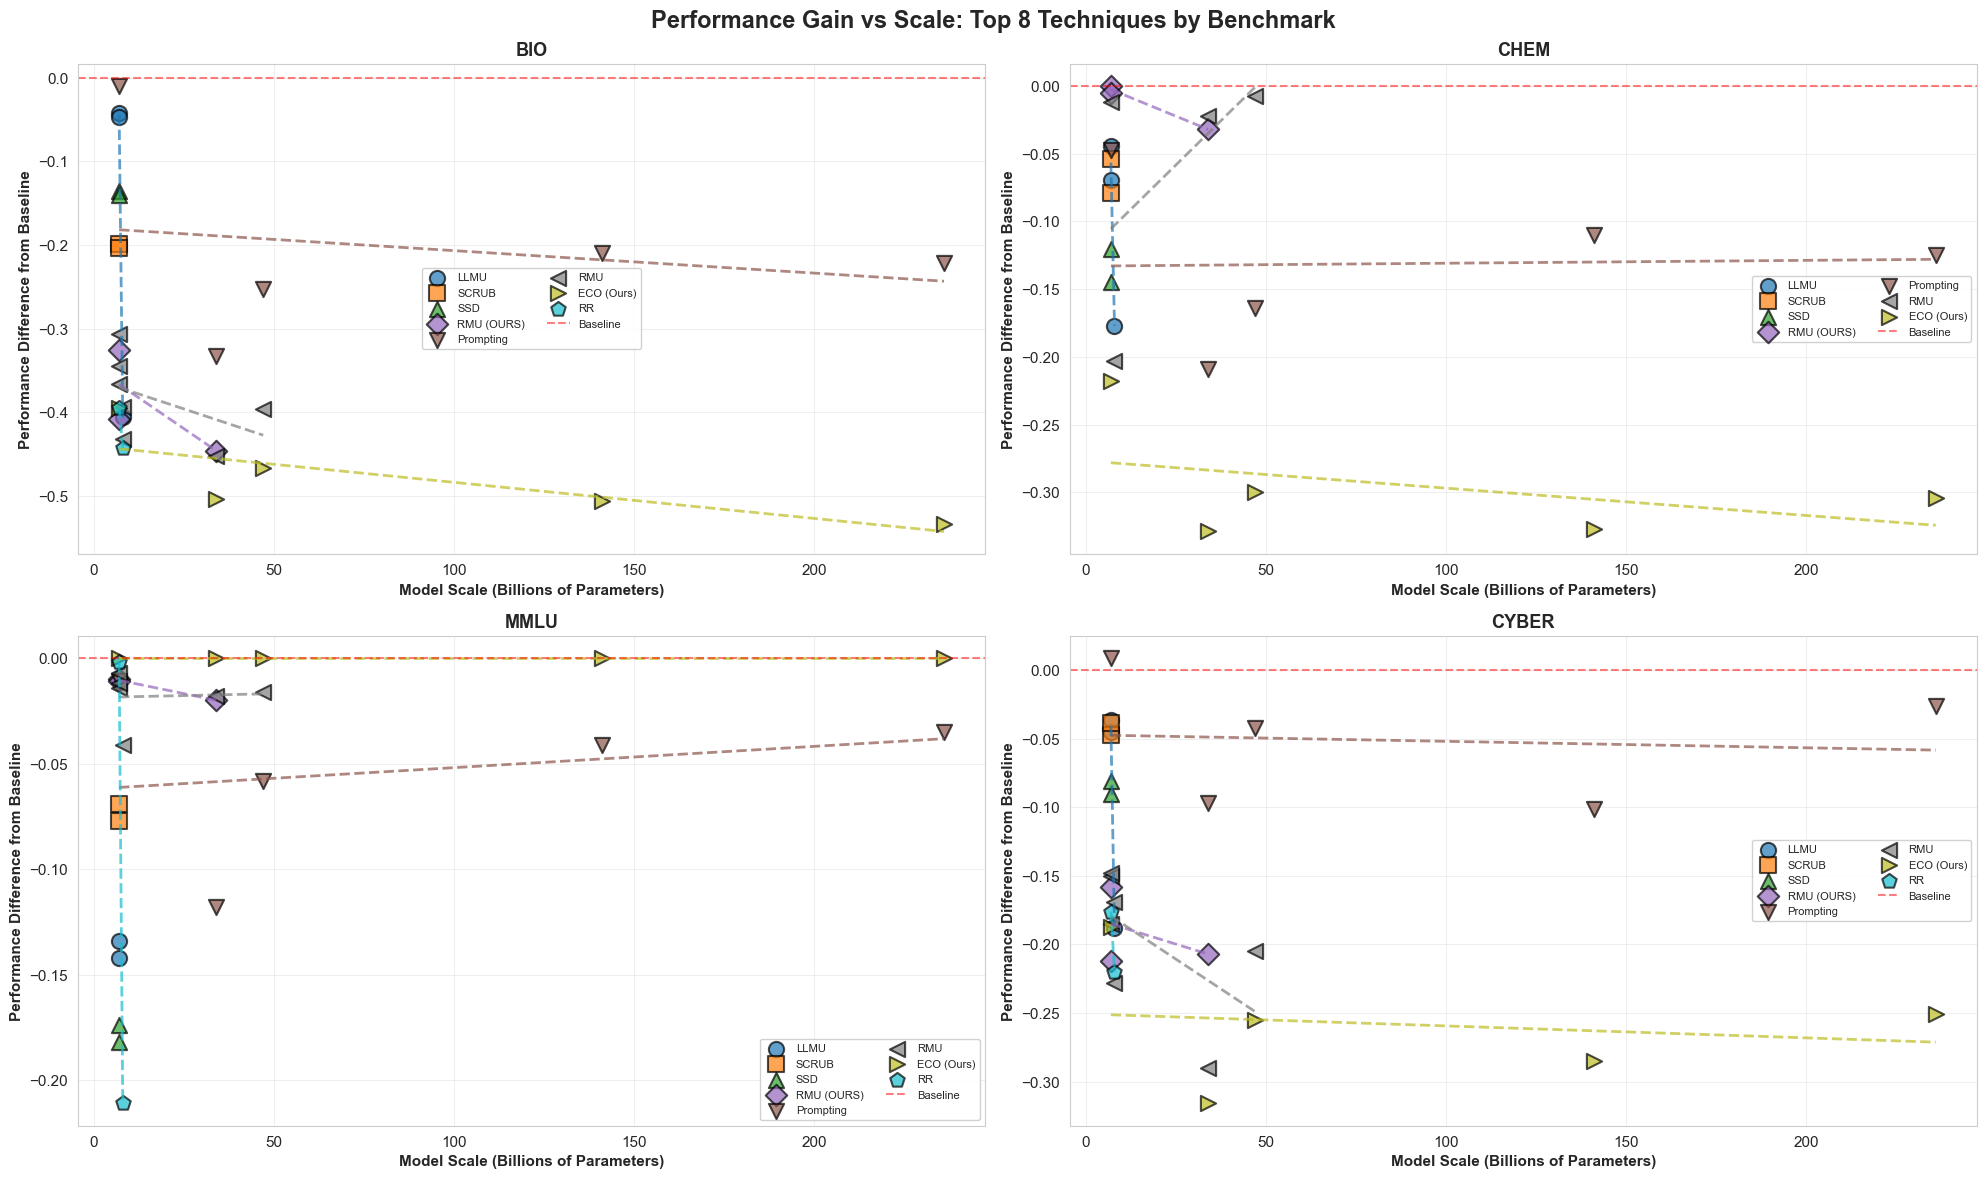


✓ Technique scaling analysis complete (showing top 8 techniques)


In [7]:
# Visualize all techniques together per benchmark
# Since we have many techniques, we'll use top techniques by data point count
top_techniques = diff_df['Technique'].value_counts().head(8).index.tolist()
diff_df_filtered = diff_df[diff_df['Technique'].isin(top_techniques)]

techniques = diff_df_filtered['Technique'].unique()
benchmarks = diff_df_filtered['Benchmark'].unique()

# Define colors using a color palette for many techniques
color_palette = plt.cm.tab10(np.linspace(0, 1, len(techniques)))
colors = {tech: color_palette[i] for i, tech in enumerate(techniques)}
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p']
marker_map = {tech: markers[i % len(markers)] for i, tech in enumerate(techniques)}

# Create subplot grid for benchmarks
n_benchmarks = len(benchmarks)
n_cols = min(2, n_benchmarks)
n_rows = (n_benchmarks + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10*n_cols, 6*n_rows))
if n_benchmarks == 1:
    axes = [axes]
else:
    axes = axes.flatten() if n_benchmarks > 1 else [axes]

for idx, benchmark in enumerate(benchmarks):
    if idx >= len(axes):
        break
    ax = axes[idx]

    # Plot all techniques on the same subplot
    for technique in techniques:
        # Get data for this technique-benchmark combination
        subset = diff_df_filtered[
            (diff_df_filtered['Technique'] == technique) &
            (diff_df_filtered['Benchmark'] == benchmark)
        ]

        if len(subset) > 0:
            # Plot individual points
            ax.scatter(subset['scale_numeric'], subset['Diff_from_baseline'],
                      s=120, alpha=0.7, color=colors[technique],
                      marker=marker_map[technique], label=technique,
                      edgecolors='black', linewidth=1.5)

            # Add trend line if enough points
            if len(subset) >= 2:
                scales = subset['scale_numeric'].values.reshape(-1, 1)
                diffs = subset['Diff_from_baseline'].values
                model = LinearRegression()
                model.fit(scales, diffs)

                scale_range = np.linspace(scales.min(), scales.max(), 100)
                pred = model.predict(scale_range.reshape(-1, 1))
                ax.plot(scale_range, pred, '--', color=colors[technique],
                       linewidth=2, alpha=0.7)

    # Add zero reference line
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='Baseline')

    # Add legend
    ax.legend(loc='best', fontsize=8, framealpha=0.9, ncol=2)

    ax.set_xlabel('Model Scale (Billions of Parameters)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Performance Difference from Baseline', fontsize=11, fontweight='bold')
    ax.set_title(f'{benchmark}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)

# Remove extra subplots if needed
for idx in range(n_benchmarks, len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle(f'Performance Gain vs Scale: Top {len(techniques)} Techniques by Benchmark',
            fontsize=17, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n✓ Technique scaling analysis complete (showing top {len(techniques)} techniques)")

## 5. Summary: Categorization by Scaling Behavior

### Benchmark Categorization
- **Saturated**: Vanilla performance increases with scale
- **Not Saturated**: Vanilla performance doesn't increase with scale

### Technique Categorization (per benchmark)
- **Gain Increases**: Performance gain grows with scale
- **Gain Stable**: Performance gain doesn't change with scale
- **Gain Decreases**: Performance gain shrinks with scale

In [8]:
# Benchmark saturation summary
print("\n" + "="*80)
print("BENCHMARK SATURATION ANALYSIS")
print("="*80)
print("\nBenchmarks by Saturation Status:")
for category in bench_scaling_df['Category'].unique():
    benchmarks = bench_scaling_df[bench_scaling_df['Category'] == category]['Benchmark'].tolist()
    print(f"\n{category}:")
    for b in benchmarks:
        stats = bench_scaling_df[bench_scaling_df['Benchmark'] == b].iloc[0]
        print(f"  - {b:20s} (corr={stats['Correlation']:6.3f}, slope={stats['Slope']:7.4f})")


BENCHMARK SATURATION ANALYSIS

Benchmarks by Saturation Status:

Saturated:
  - BIO                  (corr= 0.830, slope= 0.0004)
  - CHEM                 (corr= 0.630, slope= 0.0003)
  - MMLU                 (corr= 0.836, slope= 0.0006)
  - CYBER                (corr= 0.651, slope= 0.0002)


In [9]:
# Technique categorization summary
print("\n" + "="*80)
print("TECHNIQUE SCALING BEHAVIOR ANALYSIS")
print("="*80)

for technique in tech_scaling_df['Technique'].unique():
    print(f"\n{technique}:")
    tech_data = tech_scaling_df[tech_scaling_df['Technique'] == technique]
    
    for category in ['Gain Increases with Scale', 'Gain Stable with Scale', 'Gain Decreases with Scale']:
        cat_data = tech_data[tech_data['Category'] == category]
        if len(cat_data) > 0:
            print(f"\n  {category}:")
            for _, row in cat_data.iterrows():
                print(f"    - {row['Benchmark']:15s} (corr={row['Correlation']:6.3f}, "
                      f"slope={row['Slope']:7.4f}, mean_diff={row['Mean_diff']:7.2f})")


TECHNIQUE SCALING BEHAVIOR ANALYSIS

LLMU:

  Gain Stable with Scale:
    - MMLU            (corr=   nan, slope= 0.0000, mean_diff=  -0.14)

  Gain Decreases with Scale:
    - BIO             (corr=-0.866, slope=-0.3615, mean_diff=  -0.17)
    - CHEM            (corr=-0.866, slope=-0.1205, mean_diff=  -0.10)
    - CYBER           (corr=-0.866, slope=-0.1475, mean_diff=  -0.09)

SCRUB:

  Gain Stable with Scale:
    - BIO             (corr=   nan, slope= 0.0000, mean_diff=  -0.20)
    - CHEM            (corr=   nan, slope= 0.0000, mean_diff=  -0.07)
    - MMLU            (corr=   nan, slope= 0.0000, mean_diff=  -0.07)
    - CYBER           (corr=   nan, slope= 0.0000, mean_diff=  -0.04)

SSD:

  Gain Stable with Scale:
    - BIO             (corr=   nan, slope= 0.0000, mean_diff=  -0.14)
    - CHEM            (corr=   nan, slope= 0.0000, mean_diff=  -0.13)
    - MMLU            (corr=   nan, slope= 0.0000, mean_diff=  -0.18)
    - CYBER           (corr=   nan, slope= 0.0000, mean_diff=

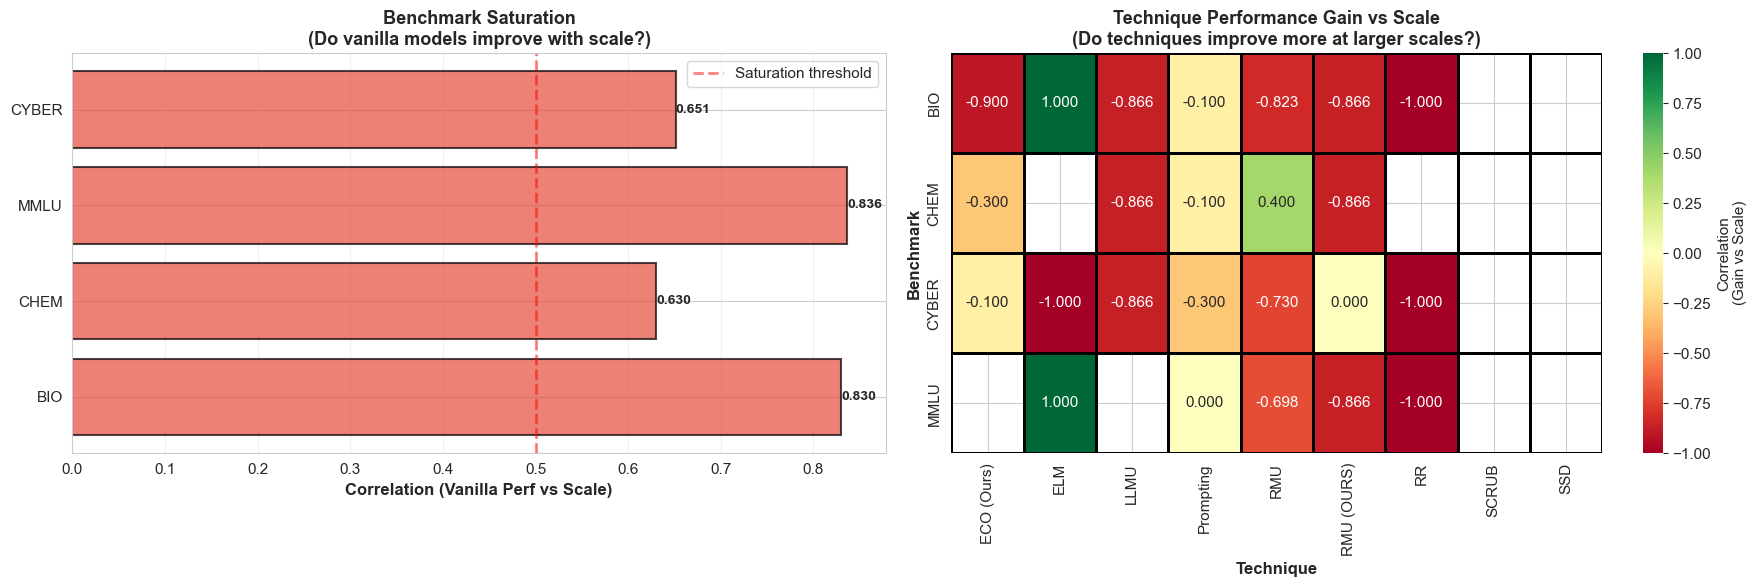


✓ Summary visualization complete


In [10]:
# Create summary visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Benchmark saturation
bench_colors = {'Saturated': '#E74C3C', 'Not Saturated': '#3498DB'}
saturated = bench_scaling_df[bench_scaling_df['Category'] == 'Saturated']
not_saturated = bench_scaling_df[bench_scaling_df['Category'] == 'Not Saturated']

y_pos = np.arange(len(bench_scaling_df))
colors_list = [bench_colors[cat] for cat in bench_scaling_df['Category']]

bars = ax1.barh(y_pos, bench_scaling_df['Correlation'], color=colors_list, alpha=0.7,
               edgecolor='black', linewidth=1.5)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(bench_scaling_df['Benchmark'])
ax1.set_xlabel('Correlation (Vanilla Perf vs Scale)', fontsize=12, fontweight='bold')
ax1.set_title('Benchmark Saturation\n(Do vanilla models improve with scale?)',
             fontsize=13, fontweight='bold')
ax1.axvline(x=0.5, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Saturation threshold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, bench_scaling_df['Correlation'])):
    ax1.text(val, bar.get_y() + bar.get_height()/2.,
            f'{val:.3f}',
            ha='left' if val > 0 else 'right',
            va='center', fontsize=10, fontweight='bold')

# Plot 2: Technique scaling summary (heatmap)
pivot_data = tech_scaling_df.pivot(index='Benchmark', columns='Technique', values='Correlation')
sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='RdYlGn', center=0,
           cbar_kws={'label': 'Correlation\n(Gain vs Scale)'},
           linewidths=1, linecolor='black', ax=ax2)
ax2.set_title('Technique Performance Gain vs Scale\n(Do techniques improve more at larger scales?)',
             fontsize=13, fontweight='bold')
ax2.set_xlabel('Technique', fontsize=12, fontweight='bold')
ax2.set_ylabel('Benchmark', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Summary visualization complete")

## 6. Conclusions and Insights

### Key Findings

#### Benchmark Saturation
- Benchmarks where vanilla models improve with scale are **naturally solved by scaling**
- Benchmarks where vanilla models don't improve need **targeted safety interventions**

#### Technique Scaling Behavior
- **Positive slope**: Technique becomes more effective at larger scales
- **Negative slope**: Technique becomes less effective at larger scales
- **Near-zero slope**: Technique effectiveness is scale-independent

### Implications

1. **Focus research** on benchmarks that are NOT saturated by scale
2. **Prioritize techniques** where performance gain increases with scale
3. **Investigate techniques** where performance gain decreases with scale

### Limitations

- **Mockup data**: Synthetic patterns, not real measurements
- **Limited scale range**: Only 3-4 scale points per model family
- **Linear assumptions**: May miss non-linear scaling effects

### Next Steps

1. **Collect real data** from published papers
2. **Test non-linear models** for scaling relationships
3. **Add more benchmarks** for robustness
4. **Consider training compute** as additional scaling metric

---

**Methodology**: Based on SafetyWashing (NeurIPS 2024)  
**Data Source**: `../data/mockup_dataset.csv`